# Generative Adversarial Networks
GANs are a unique type of neural network that pits two models against each other in order to ultimately create a model that can generate novel output when provided random noise.


In [1]:
#Imports
import torch, torchvision
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Linear, ReLU, BatchNorm1d, Sigmoid, Flatten, Unflatten, Conv2d
import matplotlib.pyplot as plt

In [2]:
SEED = 1234567890
torch.manual_seed(SEED)
# Optionally always use cpu (more efficient for smaller models)
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu" 
# DEVICE = "cpu"
IMAGE_WIDTH = 28
NOISE_SIZE = 49
print(f"Using random seed: {SEED}")
print(f"Using Device: {DEVICE}")

Using random seed: 1234567890
Using Device: mps


## Data
The raw MNIST data is stored in a [B, H, W] int8 tensor, so we need to convert and rescale the data so each pixel value lies between 0 and 1.

In [3]:
# Dataloading
class MNISTDataset(Dataset):
    def __init__(self):
        mnist_data = torchvision.datasets.MNIST('data/mnist', 
                                        download=True)
        self.data = mnist_data.data.to(dtype=torch.float32, device=DEVICE) / 255
        self.data = self.data.flatten(1)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx]

### Dataloading Preview

Take a look at the images from the dataset.

In [4]:
def display_tensor(tensor):
    images = tensor.cpu().reshape(-1, IMAGE_WIDTH, IMAGE_WIDTH).detach().numpy()
    _, ax = plt.subplots(ncols=len(images))
    for i, image in enumerate(images):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].imshow(image, cmap='gray')
    plt.show()

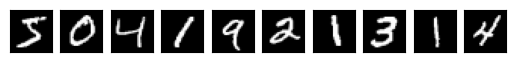

In [5]:
mnist_data = MNISTDataset()
display_tensor(mnist_data[0:10])

# Creating a Discriminator
Before we can start generating images, we need to make our discriminator, a model which will predict whether an input image is from the MNIST dataset or was generated some other way. We'll be dealing with large models, so we'll define a ResidualLayer module to make it easy to implement residual connections for speeding up training.

In [6]:
class ResidualLayer(Module):
    def __init__(self, sequential):
        super().__init__()
        self.sequential = sequential

    def forward(self, x):
        return x + self.sequential(x)

This defines the architecture of the discriminator. Feel free to play around with it if you want to see how things change!

In [7]:
# Discriminator
def create_discriminator():
    return Sequential(
            ResidualLayer(Sequential(
                BatchNorm1d(784), 
                Linear(784, 784),       
                ReLU()
            )),
            BatchNorm1d(784),
            Linear(784, 392),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(392),
                Linear(392, 392),
                ReLU()
            )),
            BatchNorm1d(392),
            Linear(392, 1),
            Sigmoid()
        ).to(device=DEVICE)

In [8]:
# Alternative Discriminator Architecture
def create_cnn_discriminator():
    return Sequential(
            Unflatten(1, (1, IMAGE_WIDTH, IMAGE_WIDTH)),
            Conv2d(1, 16, kernel_size=7, padding=3),
            ReLU(),
            Conv2d(16, 32, kernel_size=5, padding=2),
            ReLU(),
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Flatten(),
            BatchNorm1d(64 * IMAGE_WIDTH * IMAGE_WIDTH),
            Linear(64 * IMAGE_WIDTH * IMAGE_WIDTH, IMAGE_WIDTH * IMAGE_WIDTH),
            ReLU(),
            BatchNorm1d(IMAGE_WIDTH * IMAGE_WIDTH),
            Linear(IMAGE_WIDTH * IMAGE_WIDTH, 1),
            Sigmoid()
        ).to(device=DEVICE)

As a loss function, we use the negative log likelihood of making a correct prediction. To take a training step for the discriminator, we'll pass it a variety of images and labels indicating whether each image is from the MNIST dataset (1) or from our generator model (0). We can then calculate the loss, perform backpropagation, and take a gradient descent step.

In [9]:
def discriminator_loss_fn(predictions, labels, epsilon = 1e-5):
    return -torch.mean(torch.log(epsilon + 1 - torch.abs(predictions - labels))) + epsilon

# Train Discriminator    
def discriminator_train_step(discriminator, real_images, fake_images, optimizer):
    optimizer.zero_grad()

    images = torch.cat([real_images, fake_images])

    # Create labels for the samples
    labels = torch.cat((torch.ones(len(real_images), device=DEVICE), 
                        torch.zeros(len(fake_images), device=DEVICE)))
    
    # Compute predictions and update the parameters
    predictions = discriminator(images).squeeze(dim = 1)
    loss = discriminator_loss_fn(predictions, labels)
    loss.backward()
    optimizer.step()

    return loss

As a test, let's generate some images which are just noise and feed them to the discriminator to see if it can learn to distinguish complete noise from actual MNIST data.

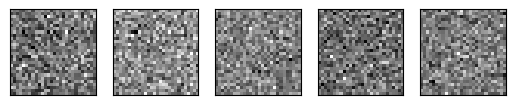

In [10]:
fake_images = torch.randn(5, IMAGE_WIDTH, IMAGE_WIDTH)
display_tensor(fake_images)

In [11]:
torch.manual_seed(SEED)

discriminator = create_discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.9))
for real_images in DataLoader(mnist_data, batch_size=256):
    # Generate random noise to train against
    fake_images = torch.randn_like(real_images)

    loss = discriminator_train_step(discriminator, real_images, fake_images, discriminator_optimizer)
    print("Loss: {:10.7f}".format(loss), end='\r')

You should see the loss get very small very quickly: we've learned to distinguish between them! Now we're ready to start generating images.

# Creating a Generator

We'll now create a feed-forward network to serve as the generator. Generating new images turns out to be a more complicated task than classifying them, so this network will be much larger than the discriminator. It takes as input a 49-element vector containing complete noise, and outputs a 784-element vector with elements between 0 and 1 which can be reshaped into an image.

In [12]:
# Generator
def create_generator():
    return Sequential(
            ResidualLayer(Sequential(
                BatchNorm1d(49),
                Linear(49, 49),
                ReLU()
            )),
            BatchNorm1d(49),
            Linear(49, 98),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(98),
                Linear(98, 98),
                ReLU()
            )),
            BatchNorm1d(98),
            Linear(98, 196),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(196),
                Linear(196, 196),
                ReLU()
            )),
            BatchNorm1d(196),
            Linear(196, 392),
            ReLU(),
            ResidualLayer(Sequential(
                BatchNorm1d(392),
                Linear(392, 392),
                ReLU()
            )),
            BatchNorm1d(392),
            Linear(392, 784),
            ResidualLayer(Sequential(
                BatchNorm1d(784),
                Linear(784, 784),
                ReLU()
            )),
            Sigmoid()
        ).to(device=DEVICE)

As a loss function, we use the negative log likelihood of the discriminator making an *incorrect* prediction, since the generator's goal is to fool the discriminator as often as possible. To take a training step for the generator, we'll pass it a batch of noise vectors, have it generate images, then send those images to the discriminator for classification. Based on the output of that model, we calculate this loss function, then perform backpropagation all the way back to the generator and take a gradient descent step.

In [13]:
def generator_loss_fn(predictions, epsilon = 1e-5):
    return -torch.mean(torch.log(epsilon + predictions))

# Train Generator
def generator_train_step(generator, discriminator, batch_size, generator_optimizer, discriminator_optimizer):
    generator_optimizer.zero_grad()
    discriminator_optimizer.zero_grad()

    noise = torch.randn(batch_size, NOISE_SIZE, device=DEVICE)
    generated_images = generator(noise)
    
    # Compute predictions and update the parameters
    predictions = discriminator(generated_images).squeeze(dim = 1)
    loss = generator_loss_fn(predictions)
    loss.backward()
    generator_optimizer.step()

    return loss

Now let's train our Model! But first we need to define some evaluation functions, so we can see what's going on.

In [14]:
# Evaluation
def evaluate(generator, discriminator, dataloader):
    # Variables for tracking stats as we iterate through the data in batches
    total_samples = 0
    correct_on_real_images = 0
    correct_on_generated_images = 0

    for batch in dataloader:
        # Get number correct on real images
        real_preds = discriminator(batch).squeeze(dim=1)
        correct_on_real_images += (real_preds > 0.5).sum()

        # Get number correct on generated images
        noise = torch.randn(len(batch), NOISE_SIZE, device=DEVICE)
        generated_preds = discriminator(generator(noise)).squeeze(dim=1)
        correct_on_generated_images += (generated_preds < 0.5).sum()
        
        # Track how many images we've seen
        total_samples += len(batch)
    
    # Calculate Accuracies
    real_correct_acc = correct_on_real_images / total_samples
    generated_correct_acc = correct_on_generated_images / total_samples

    return real_correct_acc, generated_correct_acc

-------------------------------------------------
Epoch 1


100%|██████████| 938/938 [00:35<00:00, 26.63it/s]



Real Image Accuracy:      1.0
Generated Image Accuracy: 1.0

Example images:


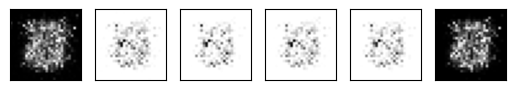

-------------------------------------------------
Epoch 2


100%|██████████| 938/938 [00:34<00:00, 27.31it/s]



Real Image Accuracy:      0.999916672706604
Generated Image Accuracy: 1.0

Example images:


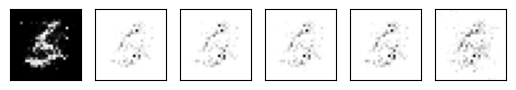

-------------------------------------------------
Epoch 3


100%|██████████| 938/938 [00:34<00:00, 27.44it/s]



Real Image Accuracy:      0.997783362865448
Generated Image Accuracy: 1.0

Example images:


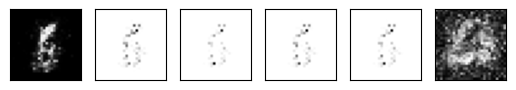

-------------------------------------------------
Epoch 4


100%|██████████| 938/938 [00:35<00:00, 26.74it/s]



Real Image Accuracy:      0.9649666547775269
Generated Image Accuracy: 1.0

Example images:


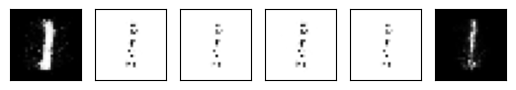

-------------------------------------------------
Epoch 5


100%|██████████| 938/938 [00:34<00:00, 27.09it/s]



Real Image Accuracy:      0.9534833431243896
Generated Image Accuracy: 0.9890333414077759

Example images:


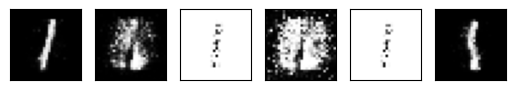

-------------------------------------------------
Epoch 6


100%|██████████| 938/938 [00:35<00:00, 26.63it/s]



Real Image Accuracy:      0.9284166693687439
Generated Image Accuracy: 0.9990333318710327

Example images:


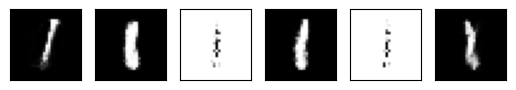

-------------------------------------------------
Epoch 7


100%|██████████| 938/938 [00:36<00:00, 26.03it/s]



Real Image Accuracy:      0.9223833084106445
Generated Image Accuracy: 0.9995333552360535

Example images:


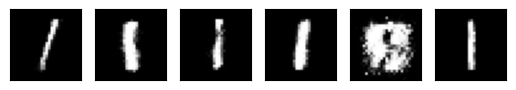

-------------------------------------------------
Epoch 8


100%|██████████| 938/938 [00:35<00:00, 26.65it/s]



Real Image Accuracy:      0.9124500155448914
Generated Image Accuracy: 0.9979666471481323

Example images:


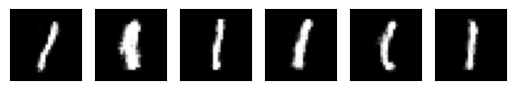

-------------------------------------------------
Epoch 9


100%|██████████| 938/938 [00:34<00:00, 27.14it/s]



Real Image Accuracy:      0.9120333194732666
Generated Image Accuracy: 0.996399998664856

Example images:


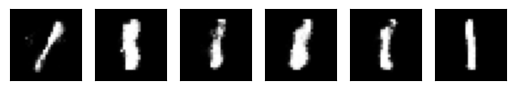

-------------------------------------------------
Epoch 10


 29%|██▉       | 273/938 [00:10<00:24, 27.31it/s]

In [16]:
torch.manual_seed(SEED)

discriminator = create_discriminator() # Try replacing this with: create_cnn_discriminator()
generator = create_generator()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002, betas=(0.5, 0.9))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = 0.0001, betas=(0.5, 0.9))

batch_size=64

test_noise = torch.randn(6, NOISE_SIZE, device=DEVICE)

for epoch in range(20):
    print("-------------------------------------------------")
    print(f"Epoch {1 + epoch}")
    # Training Loop
    for real_images in tqdm(DataLoader(mnist_data, batch_size=batch_size)):
        # Discriminator training loop
        discriminator.train()
        generator.eval()

        noise = torch.randn(batch_size, NOISE_SIZE, device=DEVICE)
        fake_images = generator(noise)
        discriminator_train_step(discriminator, real_images, fake_images, discriminator_optimizer)

        # Generator training subroutine
        discriminator.eval()
        generator.train()
        generator_train_step(generator, discriminator, batch_size, generator_optimizer, discriminator_optimizer)
    
    # Evaluate current performance
    real_correct_acc, generated_correct_acc = evaluate(generator, discriminator, DataLoader(mnist_data, batch_size=2048))
    generator.eval()
    discriminator.eval()
    print()
    print(f"Real Image Accuracy:      {real_correct_acc}")
    print(f"Generated Image Accuracy: {generated_correct_acc}")
    print()
    print("Example images:")
    display_tensor(generator(test_noise))